Configuration loaded from YAML file.
Random seed set to: 42
Initializing Generator on cpu...
Using random weights.


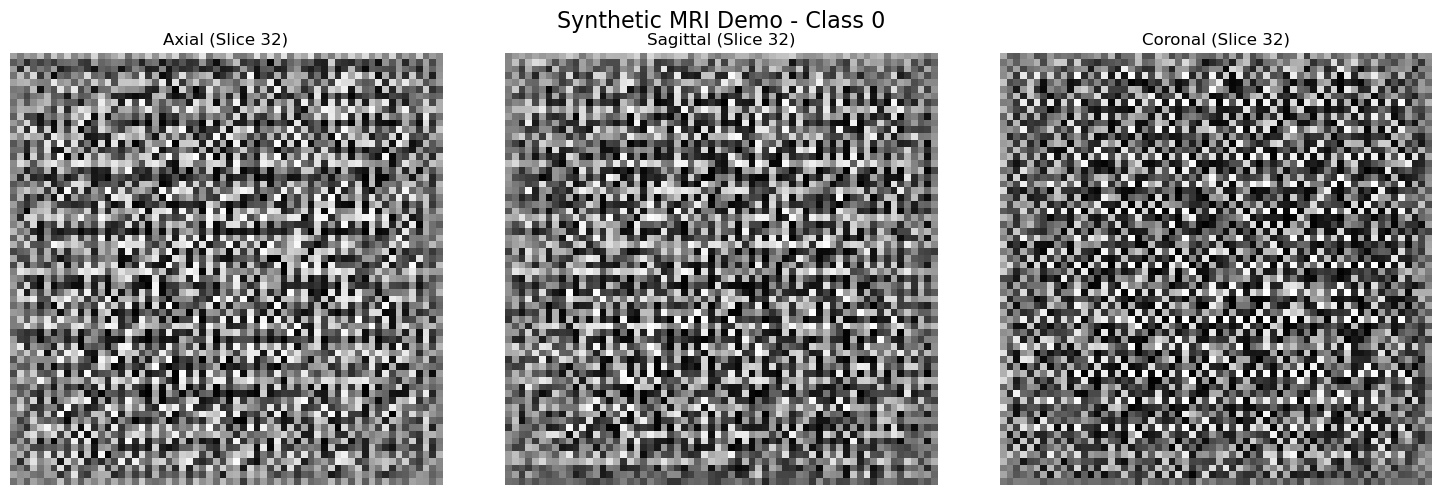

In [6]:
# -*- coding: utf-8 -*-
"""
Author: Teresa Zorzi
Date: January 2026
Description: Demo Notebook to generate and visualize synthetic MRI brain scans.
"""

import os
import sys
import glob
import torch
import matplotlib.pyplot as plt
import yaml

# --- PATH SETUP ---
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from src.models import CPUOptimizedGenerator3D
except ImportError:
    raise ImportError(
        f"Could not import 'src'. Ensure the project root is correct: {project_root}"
    )

def load_config(config_path_rel='config.yaml'):
    """
    Load configuration from a YAML file.

    Parameters
    ----------
    config_path_rel : str
        Path to the config file relative to the project root.

    Returns
    -------
        dict
            Configuration parameters loaded from the YAML file.
    """
    full_path = os.path.join(project_root, config_path_rel)
    with open(full_path, 'r') as f:
        return yaml.safe_load(f)

%matplotlib inline

def load_latest_checkpoint(model, checkpoint_dir_rel):
    """
    Search for the latest .pth file in the checkpoint directory and load it.

    Parameters
    ----------
    model : torch.nn.Module
        The neural network model instance to populate.
    checkpoint_dir_rel : str
        Path to the checkpoints directory relative to the project root.

    Returns
    -------
    torch.nn.Module
        The model with loaded weights (or random weights if no checkpoint found).
    """
    # Build absolute path to avoid ambiguity
    full_checkpoint_dir = os.path.join(project_root, checkpoint_dir_rel)
    
    if not os.path.exists(full_checkpoint_dir):
        print(f"Warning: Directory not found: {full_checkpoint_dir}")
        print("Using random weights (output will be noise).")
        return model

    list_of_files = glob.glob(os.path.join(full_checkpoint_dir, '*.pth'))   
    if not list_of_files:
        print("Warning: No .pth checkpoints found.")
        print("Using random weights.")
        return model

    latest_file = max(list_of_files, key=os.path.getctime)   
    print(f"Loading weights from: {os.path.basename(latest_file)}")
    
    try:
        model.load_state_dict(torch.load(latest_file, map_location=torch.device('cpu')))
        print("Weights loaded successfully.")
    except Exception as e:
        print(f"Error loading weights: {e}")
    
    return model


def show_generated_brain(latent_dim=64, num_classes=3, ngf=32, target_shape=(64, 64, 64), seed=None):
    """
    Generate a random 3D MRI volume and visualize its orthogonal slices.

    Parameters
    ----------
    latent_dim : int
        Dimension of the latent vector z (must match training config).
    num_classes : int
        Number of classes for conditional generation.
    ngf : int
        Number of generator feature maps (must match training config).
    target_shape : tuple
        Desired output shape of the generated volume (Depth, Height, Width).
    """
    if seed is not None:
        import random
        import numpy as np
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        print(f"Random seed set to: {seed}")

    device = torch.device("cpu")
    print(f"Initializing Generator on {device}...")

    netG = CPUOptimizedGenerator3D(
        latent_dim=latent_dim, 
        num_classes=num_classes, 
        ngf=ngf, 
        target_shape=target_shape).to(device)
    
    # Load weights using the relative path expected by the project structure
    netG = load_latest_checkpoint(netG, os.path.join("results", "checkpoints"))
    netG.eval() 
    
    z = torch.randn(num_classes, latent_dim).to(device) 
    # Use Class 0 (e.g., AD) as a standard example
    fake_label = torch.arange(num_classes).to(device)
    
    with torch.no_grad():
        # Shape: (num_classes, 1, D, H, W)
        fake_brain = netG(z, fake_label).cpu().numpy() 
   
    # Visualize the middle slices in axial, sagittal, and coronal views for the first class
    sample_brain = fake_brain[0, 0, :, :, :]
    depth, height, width = sample_brain.shape
    mid_d, mid_h, mid_w = depth // 2, height // 2, width // 2

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Axial View
    axes[0].imshow(sample_brain[mid_d, :, :], cmap='gray')
    axes[0].set_title(f"Axial (Slice {mid_d})")
    axes[0].axis('off')
    
    # Sagittal View
    axes[1].imshow(sample_brain[:, mid_h, :], cmap='gray')
    axes[1].set_title(f"Sagittal (Slice {mid_h})")
    axes[1].axis('off')
    
    # Coronal View
    axes[2].imshow(sample_brain[:, :, mid_w], cmap='gray')
    axes[2].set_title(f"Coronal (Slice {mid_w})")
    axes[2].axis('off')
    
    plt.suptitle(f"Synthetic MRI Demo - Class {fake_label[0].item()}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Entry point
if __name__ == "__main__":
    try:
        cfg = load_config()
        print("Configuration loaded from YAML file.")
        
        show_generated_brain(
            latent_dim=cfg['model']['latent_dim'],
            num_classes=cfg['model']['num_classes'],
            ngf=cfg['model']['ngf'],
            target_shape=tuple(cfg['dataset']['target_shape']),
            seed=cfg['training']['seed']
        )
    except FileNotFoundError:
        print(f"ERROR: config.yaml file not found in {project_root}")
    except KeyError as e:
        print(f"ERROR: Missing key in configuration file: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")